In [1]:
!pip install xgboost

In [2]:
!pip install graphviz

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import graphviz

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import time

In [4]:
pd.set_option('display.max_columns', None)


In [5]:
df = pd.read_csv('churn_data.csv')
# converts total charges from string to float
df['Total Charges'] = df['Total Charges'].replace(r'^\s*$', np.nan, regex=True)
df['Total Charges'] = df['Total Charges'].astype(float)

df = df.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Churn Reason', 'Churn Score', 'Churn Label', 'CLTV'], axis=1)
df = df.drop(['Zip Code', 'Lat Long', 'Latitude', 'Longitude'], axis=1)

X = df.drop('Churn Value', axis=1).copy()
y = df['Churn Value'].copy()

# Using One Hot Encoding

X_encoded = pd.get_dummies(X, columns=['Gender',
       'Senior Citizen', 'Partner', 'Dependents',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method'], drop_first=True)

X_encoded.head()
X_encoded.columns

X_encoded = X_encoded.drop(['Online Security_No internet service', 'Device Protection_No internet service', 'Tech Support_No internet service'
                           ,'Streaming TV_No internet service', 'Streaming Movies_No internet service'], axis=1)

# Standard scaling on numerical variables

scaler = StandardScaler()
X_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']] = scaler.fit_transform(X_encoded[['Tenure Months', 'Monthly Charges', 'Total Charges']])
X_encoded

,Tenure Months,Monthly Charges,Total Charges,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_Yes,Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,-1.236724,-0.362660,-0.959649,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1
1,-1.236724,0.197365,-0.940457,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,-0.992402,1.159546,-0.645369,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0
3,-0.177995,1.330711,0.336516,0,0,1,1,1,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,0
4,0.677133,1.294151,1.214589,1,0,0,1,1,0,1,1,0,0,0,1,1,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.613701,-1.449476,-0.381142,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
7039,-0.340876,0.665992,-0.129180,1,0,1,1,1,0,1,0,0,1,0,0,1,1,1,1,1,0,1,0,0,1
7040,1.613701,1.277533,2.241056,0,0,1,1,1,0,1,1,0,0,0,1,1,0,1,1,1,0,1,1,0,0
7041,-0.870241,-1.168632,-0.854514,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0


# Modelling

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [8]:
# Hyperparameter tuning

# Iteration 1
#param_grid = {
#    'max_depth': [3, 4, 5, 6],
#    'learning_rate': [0.3, 0.2, 0.1],
#    'gamma': [0, 0.25, 1.0],
#    'reg_lambda': [0, 1.0, 10.0]
#}
# {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'reg_lambda': 0}

# Iteration 2
#param_grid = {
#    'max_depth': [5, 6, 7],
#    'learning_rate': [0.1, 0.50, 0.025],
#    'gamma': [0.5, 1.0, 1.5],
#    'reg_lambda': [0.0, 1.0]
#}
# Results {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.0}

# Iteration 3
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.5, 0.1, 1.5],
    'gamma': [0.5, 1, 0.25],
    'reg_lambda': [0]
}
## Results {'gamma': 0.3, 'learning_rate': 0.125, 'max_depth': 3, 'reg_lambda': 17}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv=3
)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\farra\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\farra\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0}


In [9]:
# Fitting XGBoost model with optimal parameters
# Optimal parameters found above{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.0}

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=1, seed=42, gamma=0.25
                            ,learning_rate=0.1, max_depth=5, reg_lambda=0.0)
clf_xgb.fit(X_train,
            y_train,
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.83760
[1]	validation_0-auc:0.84249
[2]	validation_0-auc:0.84363
[3]	validation_0-auc:0.84547
[4]	validation_0-auc:0.84642
[5]	validation_0-auc:0.84850
[6]	validation_0-auc:0.84942
[7]	validation_0-auc:0.85012
[8]	validation_0-auc:0.84978
[9]	validation_0-auc:0.85309
[10]	validation_0-auc:0.85320
[11]	validation_0-auc:0.85299
[12]	validation_0-auc:0.85387
[13]	validation_0-auc:0.85427
[14]	validation_0-auc:0.85418
[15]	validation_0-auc:0.85564
[16]	validation_0-auc:0.85498
[17]	validation_0-auc:0.85557
[18]	validation_0-auc:0.85568
[19]	validation_0-auc:0.85524
[20]	validation_0-auc:0.85575
[21]	validation_0-auc:0.85632
[22]	validation_0-auc:0.85684
[23]	validation_0-auc:0.85712
[24]	validation_0-auc:0.85729
[25]	validation_0-auc:0.85779
[26]	validation_0-auc:0.85824
[27]	validation_0-auc:0.85853
[28]	validation_0-auc:0.85840
[29]	validation_0-auc:0.85858
[30]	validation_0-auc:0.85892
[31]	validation_0-auc:0.85940
[32]	validation_0-auc:0.85976
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=1, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Model Evaluation

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = clf_xgb.predict(X_test)
predictions = [np.round(value) for value in y_pred]
confusion_matrix(y_test, y_pred)


array([[913, 349],
       [ 87, 412]], dtype=int64)

In [21]:
y_pred_train = clf_xgb.predict(X_train)
predictions = [round(value) for value in y_pred_train]
confusion_matrix(y_train, y_pred_train)



array([[2956,  956],
       [ 390, 3522]], dtype=int64)

In [12]:
auc = roc_auc_score(y_test, y_pred)

print("AUC: ", auc)

auc = roc_auc_score(y_train, y_pred_train)

print("AUC: ", auc)

AUC:  0.7745530681013373
AUC:  0.8279652351738241


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1262
           1       0.54      0.83      0.65       499

    accuracy                           0.75      1761
   macro avg       0.73      0.77      0.73      1761
weighted avg       0.81      0.75      0.76      1761



In [14]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      3912
           1       0.79      0.90      0.84      3912

    accuracy                           0.83      7824
   macro avg       0.83      0.83      0.83      7824
weighted avg       0.83      0.83      0.83      7824



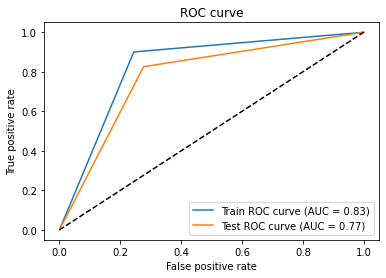

In [15]:
train_auc = roc_auc_score(y_train, y_pred_train)
train_fpr, train_tpr, _ = roc_curve(y_train, y_pred_train)

# test_predictions: predicted binary labels for test set
# test_targets: true binary labels for test set
test_auc = roc_auc_score(y_test, y_pred)
test_fpr, test_tpr, _ = roc_curve(y_test, y_pred)

# plot ROC curves
plt.plot(train_fpr, train_tpr, label='Train ROC curve (AUC = %0.2f)' % train_auc)
plt.plot(test_fpr, test_tpr, label='Test ROC curve (AUC = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

weight:  {'Tenure Months': 153.0, 'Monthly Charges': 288.0, 'Total Charges': 221.0, 'Gender_Male': 10.0, 'Senior Citizen_Yes': 25.0, 'Partner_Yes': 38.0, 'Dependents_Yes': 94.0, 'Phone Service_Yes': 13.0, 'Multiple Lines_Yes': 18.0, 'Internet Service_Fiber optic': 19.0, 'Internet Service_No': 11.0, 'Online Security_Yes': 19.0, 'Online Backup_Yes': 10.0, 'Device Protection_Yes': 7.0, 'Tech Support_Yes': 17.0, 'Streaming TV_Yes': 16.0, 'Streaming Movies_Yes': 17.0, 'Contract_One year': 30.0, 'Contract_Two year': 34.0, 'Paperless Billing_Yes': 26.0, 'Payment Method_Credit card (automatic)': 9.0, 'Payment Method_Electronic check': 30.0, 'Payment Method_Mailed check': 11.0}
gain:  {'Tenure Months': 17.238080978393555, 'Monthly Charges': 8.836872100830078, 'Total Charges': 9.82917594909668, 'Gender_Male': 6.12105655670166, 'Senior Citizen_Yes': 6.928555488586426, 'Partner_Yes': 10.012654304504395, 'Dependents_Yes': 24.06586265563965, 'Phone Service_Yes': 5.867687702178955, 'Multiple Lines_Ye

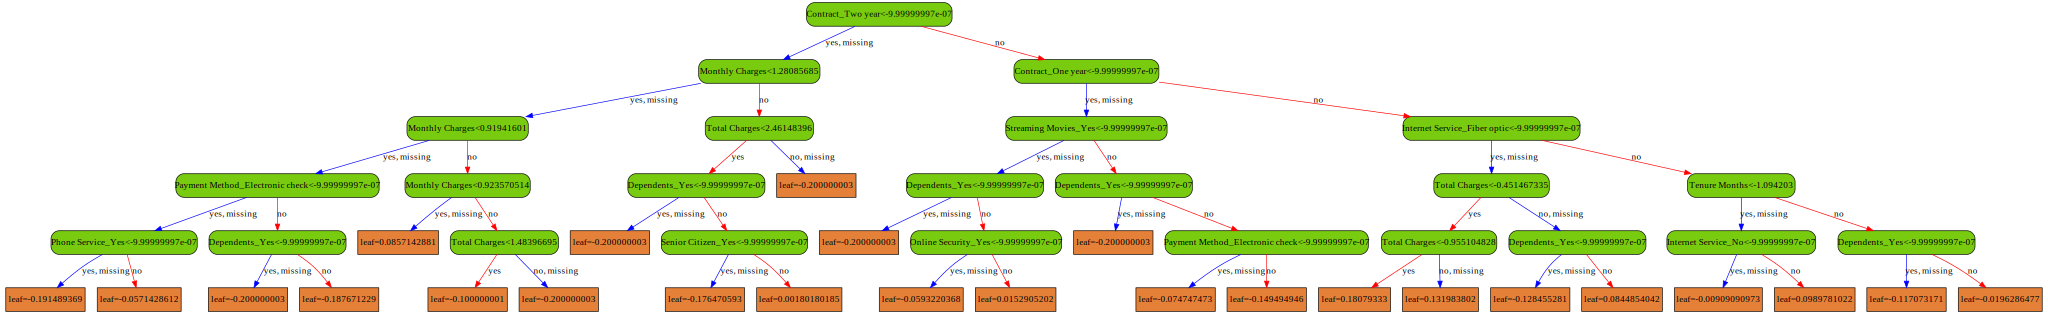

In [16]:
# Graphing the XGBoost model
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, figsize="1, 1", 
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

# Save tree to pdf file
#graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, figsize="1, 1", 
#                condition_node_params=node_params,
#                leaf_node_params=leaf_params)
#graph_data.view(filename='xgboost_tree_car_insurance_iteration_1')

In [18]:
from sklearn.metrics import f1_score

y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

y_train_prob = clf_xgb.predict(X_train)
y_test_prob = clf_xgb.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_roc_auc = roc_auc_score(y_train, y_train_prob)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")
print(f"Train ROC-AUC Score: {train_roc_auc}")
print(f"Test ROC-AUC Score: {test_roc_auc}")

Train F1 Score: 0.8395709177592372
Test F1 Score: 0.6539682539682539
Train ROC-AUC Score: 0.8279652351738241
Test ROC-AUC Score: 0.7745530681013373


Evaluation of XGBoost model:
Training set:
F1 Score (Per Class): [0.81454946 0.83957092]
AUC Score: 0.8279652351738241


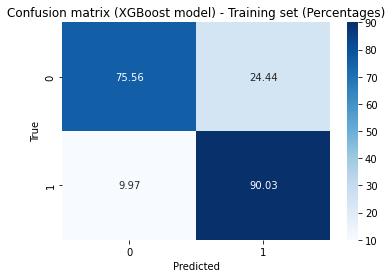

Test set:
F1 Score (Per Class): [0.80725022 0.65396825]
AUC Score: 0.7745530681013373


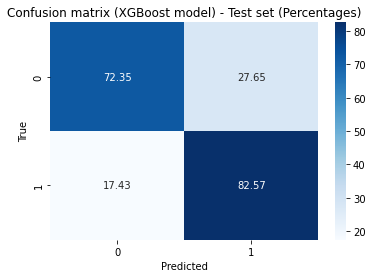

In [19]:
def evaluate_model(name, train_preds, test_preds):
    print(f"Evaluation of {name} model:")
    print("Training set:")
    print("F1 Score (Per Class):", f1_score(y_train, np.round(train_preds), average=None))
    print("AUC Score:", roc_auc_score(y_train, train_preds))
    
    cm_train = confusion_matrix(y_train, np.round(train_preds))
    cm_train_percent = cm_train / cm_train.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_train_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Training set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Test set:")
    print("F1 Score (Per Class):", f1_score(y_test, np.round(test_preds), average=None))
    print("AUC Score:", roc_auc_score(y_test, test_preds))
    
    cm_test = confusion_matrix(y_test, np.round(test_preds))
    cm_test_percent = cm_test / cm_test.sum(axis=1, keepdims=True) * 100
    sns.heatmap(cm_test_percent, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion matrix ({name} model) - Test set (Percentages)")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model('XGBoost', y_train_prob, y_test_prob)